In [1]:
import torch.nn as nn
import torch
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt

from operator import itemgetter

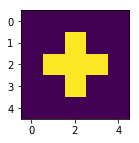

In [2]:
plt.figure(figsize=(2,2))
img = np.array([[0,0,0,0,0],[0,0,1,0,0],[0,1,1,1,0],[0,0,1,0,0],[0,0,0,0,0]])
plt.imshow(img)

In [2]:
resnet18 = models.resnet18(pretrained=True)
alexnet = models.alexnet(pretrained=True)
squeezenet = models.squeezenet1_0(pretrained=True)
vgg16 = models.vgg16(pretrained=True)
inception = models.inception_v3(pretrained=True)
model_list = [resnet18, alexnet, squeezenet, vgg16, inception]

//anaconda/envs/py36/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
//anaconda/envs/py36/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


In [3]:
all_3x3_filters = []
for model in model_list:
    model_contains_3x3 = False
    for param in model.parameters():
        if (len(param.shape) > 3) and param.shape[2] == 3 and param.shape[3] == 3:
            all_3x3_filters.append(param)
            model_contains_3x3 = True
    print(model_contains_3x3)

True
True
True
True
True


In [4]:
input_convs = []
output_convs = []
weights = []
for param in all_3x3_filters:
    #print(param[0].shape)
    for conv33 in param[0]:
        conv33 = conv33.detach()
        conv33.requires_grad = False
        input_convs.append(conv33)
        for weight in input_convs[0].view(-1):
            weights.append(weight)
        
    for conv33 in param[1]:
        conv33 = conv33.detach()
        conv33.requires_grad = False
        output_convs.append(conv33)
        for weight in output_convs[0].view(-1):
            weights.append(weight)
    #print(param.shape)

In [5]:
print(min(weights).item(), max(weights).item(), len(weights), 
      len(weights)//9, torch.mean(torch.tensor(weights)).item())

-0.7993080019950867 0.06557068973779678 191052 21228 -0.05672037973999977


In [4]:
## 35 total values, so there are 35^9 possible combinations of filters 
rounded_weights = list(np.arange(-0.80,0.075, 0.025))

In [5]:
k=len(weights)//9
N=35**9
collision_prob = np.exp(-k*(k-1)/ 2*N)

35

In [7]:
def return_closest(number, list_):
    return min(list_, key=lambda x:abs(x-number))
    

def round_to_list(conv_filter, rounding_list):
    for i in range(conv_filter.shape[0]):
        for j in range(conv_filter.shape[1]):
            conv_filter[i,j] = return_closest(conv_filter[i,j], rounded_weights)
    return conv_filter

In [8]:
#round_to_list(input_convs[3], rounded_weights)

In [9]:
for i,conv_filter in enumerate(input_convs):
    input_convs[i] = round_to_list(input_convs[i], rounded_weights)

In [10]:
filter_count_list = []
for i,conv_filter in enumerate(input_convs):
    in_list = False
    for filter_info in filter_count_list:
        if torch.equal(conv_filter, filter_info[0]):
            in_list = True
            filter_info[1] += 1
    if not in_list:
        filter_count_list.append([conv_filter,1])

In [11]:
counts = [count for _,count in filter_count_list]

In [12]:
#filter_count_list

In [13]:
u_counts = set(counts)

In [14]:
len(u_counts)

44

In [ ]:
## What is the most common filter? 0!
## I didn't include it in the following plots because of how much it threw off the scale
print(np.round(sorted_filter_list[-1][0].numpy(), decimals=3), sorted_filter_list[-1][1])

Text(0,0.5,'Number of times filters were used (unique)')

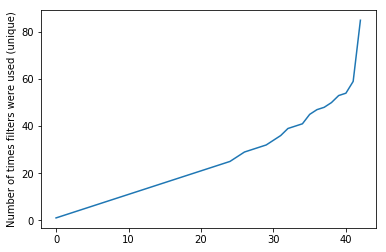

In [15]:
## Counts
plt.plot(range(len(u_counts)-1), sorted(list(u_counts))[:-1])
plt.xticks=[]
plt.ylabel("Number of times filters were used (unique)")

Text(0,0.5,'Number of times filters were used')

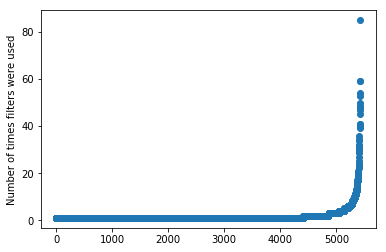

In [16]:
## Counts
plt.scatter(range(len(counts)-1), sorted(list(counts))[:-1])
plt.ylabel("Number of times filters were used")

# TODO - Calculate how many times we'd expect to see collisions if this was just chance
 - also see if this is an 80/20 rule, i.e. see how much of the total filter the top 20 convs accounted for

## Lets take a look at popular filters
 - and their effects on a sample image

In [37]:
from scipy.signal import convolve2d

In [17]:
sorted_filter_list = (sorted(filter_count_list, key=itemgetter(1)))

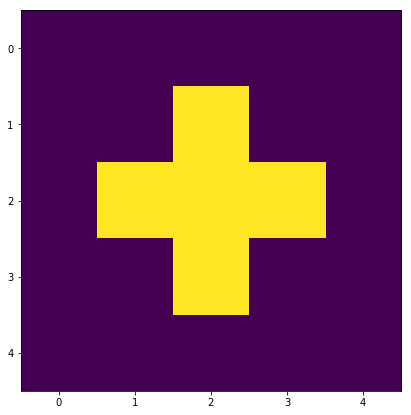

In [56]:
plt.figure(figsize=(7,7))
img = np.array([[0,0,0,0,0],[0,0,1,0,0],[0,1,1,1,0],[0,0,1,0,0],[0,0,0,0,0]])
plt.imshow(img)

In [58]:
## With Padding
plt.figure(figsize=(200,200))
for i in range(len(sorted_filter_list)):
    plt.subplot(9,9,i+1)
    convolved = convolve2d(img.copy(), sorted_filter_list[-i-1][0].numpy(), mode="same")
    plt.imshow(convolved)
    if i == 80: break

In [ ]:
## Without Padding
plt.figure(figsize=(200,200))
for i in range(len(sorted_filter_list)):
    plt.subplot(9,9,i+1)
    convolved = convolve2d(img.copy(), sorted_filter_list[-i-1][0].numpy())
    plt.imshow(convolved)
    if i == 80: break

# Todo - Dot, Line, Square

In [ ]:
## Null Hypothesis - these collisions happened by chance
## H_1 - there is another reason these patterns appear often